<font color='green' size=+2><b>Краткое описание задачи</b></font><br>



Интернет-магазин продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Нам предстоит разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность, а именно, создать модель которая подскажеть на каких клиентов стоить обратить пристальное внимание и дать рекомендации по их удержанию, увеличению покупательской активности и росту прибыли интернет-магазина!

In [1]:
!pip install shap -q
!pip install scikit-learn==1.3.2 -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score
from sklearn.svm import SVC

from sklearn.datasets import make_classification
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
market_df = pd.read_csv('/datasets/market_file.csv', delimiter=',', decimal='.')
market_money_df = pd.read_csv('/datasets/market_money.csv', delimiter=',', decimal='.')
market_time_df = pd.read_csv('/datasets/market_time.csv', delimiter=',', decimal='.')
money_df = pd.read_csv('/datasets/money.csv', delimiter=';', decimal=',')

market_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [3]:
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [4]:
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [5]:
money_df.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [6]:
def df_info(data):
    return (data.info(), data.describe())

In [7]:
df_info(market_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

(None,
                   id  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
 count    1300.000000         1300.000000           1300.000000   1300.000000   
 mean   215997.500000            4.253769              4.011538    601.898462   
 std       375.421985            1.014814              0.696868    249.856289   
 min    215348.000000            0.900000              3.000000    110.000000   
 25%    215672.750000            3.700000              4.000000    405.500000   
 50%    215997.500000            4.200000              4.000000    606.000000   
 75%    216322.250000            4.900000              4.000000    806.000000   
 max    216647.000000            6.600000              5.000000   1079.000000   
 
        Акционные_покупки  Средний_просмотр_категорий_за_визит  \
 count        1300.000000                           1300.00000   
 mean            0.319808                              3.27000   
 std             0.249843                              1.35535  

In [8]:
df_info(market_money_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


(None,
                   id        Выручка
 count    3900.000000    3900.000000
 mean   215997.500000    5025.696051
 std       375.325686    1777.704104
 min    215348.000000       0.000000
 25%    215672.750000    4590.150000
 50%    215997.500000    4957.500000
 75%    216322.250000    5363.000000
 max    216647.000000  106862.200000)

Наблюдаем очень выское максимальное значение выручки, стоит проверить

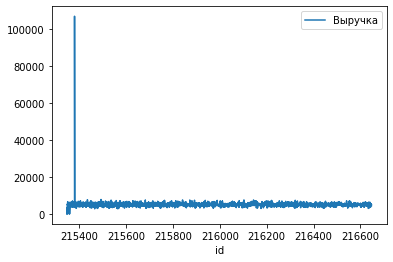

In [9]:
market_money_df.plot(x='id', y='Выручка');

In [10]:
market_money_df[market_money_df['Выручка'] == market_money_df['Выручка'].max()]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [11]:
market_money_df = market_money_df.drop(index=[98])

In [12]:
df_info(market_time_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


(None,
                   id        минут
 count    2600.000000  2600.000000
 mean   215997.500000    13.336154
 std       375.349754     4.080198
 min    215348.000000     4.000000
 25%    215672.750000    10.000000
 50%    215997.500000    13.000000
 75%    216322.250000    16.000000
 max    216647.000000    23.000000)

In [13]:
df_info(money_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


(None,
                   id      Прибыль
 count    1300.000000  1300.000000
 mean   215997.500000     3.996631
 std       375.421985     1.013722
 min    215348.000000     0.860000
 25%    215672.750000     3.300000
 50%    215997.500000     4.045000
 75%    216322.250000     4.670000
 max    216647.000000     7.430000)

<font color='green' size=+2><b>Предобработка данных</b></font><br>

In [14]:
def new_col_name(df):
    df.columns = df.columns.str.lower()
    df = df.rename(columns=lambda col: col.replace(" ", "_"))
    return df

In [15]:
market_df = new_col_name(market_df)
market_money_df = new_col_name(market_money_df)
market_time_df = new_col_name(market_time_df)
money_df = new_col_name(money_df)

Избавимся от опечаток и дублей, при их наличии.

In [16]:
market_df[market_df.duplicated()]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит


In [17]:
market_money_df[market_money_df.duplicated()]

,id,период,выручка


In [18]:
market_money_df = market_money_df.drop_duplicates().reset_index(drop=True)

In [19]:
market_time_df[market_time_df.duplicated()]

,id,период,минут


In [20]:
money_df[money_df.duplicated()]

,id,прибыль


In [21]:
market_df['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [22]:
market_df['тип_сервиса'] = market_df['тип_сервиса'].replace('стандартт', 'стандарт')
market_df['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [23]:
market_time_df['период'].unique() 

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [24]:
market_time_df['период'] = market_time_df['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time_df['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

<font color='green' size=+2><b>Исследовательский анализ</b></font><br>

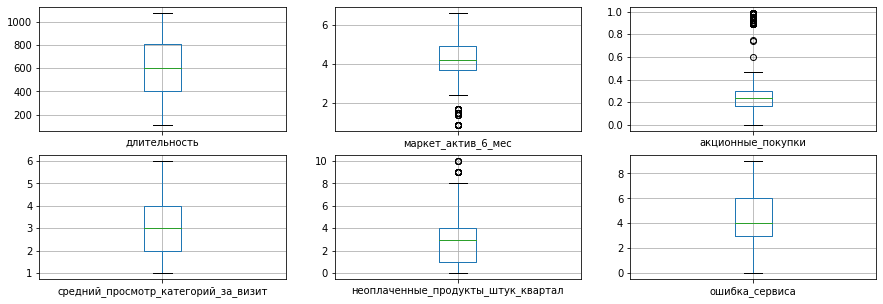

In [25]:
columns = ['длительность', 'маркет_актив_6_мес', 'акционные_покупки', 'средний_просмотр_категорий_за_визит',
           'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса']
def boxplot_func(data, columns):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
    for i, column in enumerate(columns):
        row_index = i // 3
        col_index = i % 3
        data.boxplot(column=column, ax=axes[row_index, col_index])
boxplot_func(market_df, columns)

Можно заметить выбросы в столбце 'акционные_покупки', вероятно, естьпользователи которые закупаются исключительно по акциям, либо совершают большое количество покупок во время скидок.

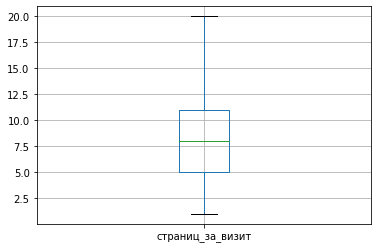

In [26]:
market_df.boxplot(column='страниц_за_визит');

Наблюдаем выбросы в столбцах 'маркет_актив_6_мес', 'акционные_покупки' и 'неоплаченные_продукты_штук_квартал'.

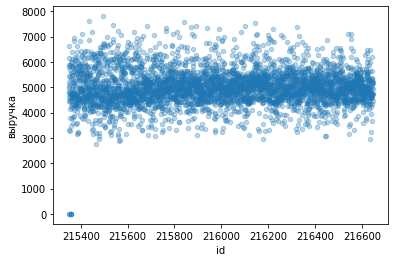

In [27]:
market_money_df.plot(x='id', y='выручка', kind='scatter', alpha=0.3);

Осталось еще несколько аномально низких значений, посмотрим на них

In [28]:
market_money_df.query('выручка < 1000')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Три пользователя, которые не потратиили ни рубля в прошлом мясяце и позапрошлом месяце. Отберем пользователей, которые делали какие-либо покупки за последние 3 месяца. 

In [29]:
mm_filtred = market_money_df.query('выручка != 0')
mm_filtred

,id,период,выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
...,...,...,...
3894,216646,препредыдущий_месяц,4725.0
3895,216646,предыдущий_месяц,4923.0
3896,216647,предыдущий_месяц,4720.0
3897,216647,препредыдущий_месяц,5183.0


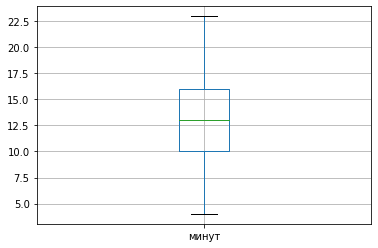

In [30]:
market_time_df.boxplot(column='минут');

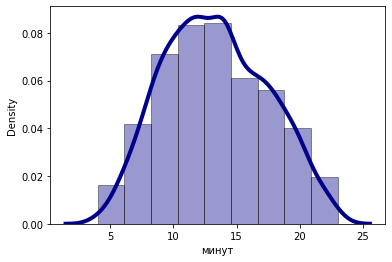

In [31]:
sns.distplot(market_time_df['минут'], hist=True, kde=True, 
             bins=9, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

В датафреймме market_time выбросов не наблюдается, данные распределены в диапазоне от 4 до 23, само распределение - похоже на нормальное.

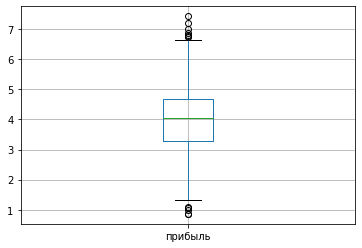

In [32]:
money_df.boxplot(column='прибыль');

Наблюдаем выбросы в обе стороны от min и max value

<font color='green' size=+1><b>Выводы исследовательского анализа</b></font><br>



В рамках исследовательского анализа мы более детально ознакомились с данными. Обнаружили выбросы в некоторых метриках 'маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал'. Отобрали активных покупателей. Так же обнаружили некоторое количество выбросов в 'money_df' столбце 'прибыль'.

<font color='green' size=+2><b>Объединение таблиц</b></font><br>

In [33]:
mm_filtred_pivot = mm_filtred.pivot_table(index='id', values='выручка', columns='период', aggfunc='sum')

In [34]:
market_time_pivot = market_time_df.pivot_table(
    index='id', 
    values='минут', 
    columns='период', 
    aggfunc='sum').rename(columns={'предыдущий_месяц':'мин_предыдущий_месяц',
                                   'текущий_месяц':'мин_текущий_месяц'})

In [35]:
merged_df = market_df.merge(mm_filtred_pivot, how='inner', on='id').reset_index(drop=True)

In [36]:
merged_df = merged_df.merge(market_time_pivot, how='inner', on='id').reset_index(drop=True)
merged_df

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,мин_предыдущий_месяц,мин_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [37]:
merged_df.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц                       3
препредыдущий_месяц                    3
текущий_месяц                          1
мин_предыдущий_месяц                   0
мин_текущий_месяц                      0
dtype: int64

In [38]:
merged_df = merged_df.dropna()

<font color='green' size=+2><b>Корреляционный анализ</b></font><br>

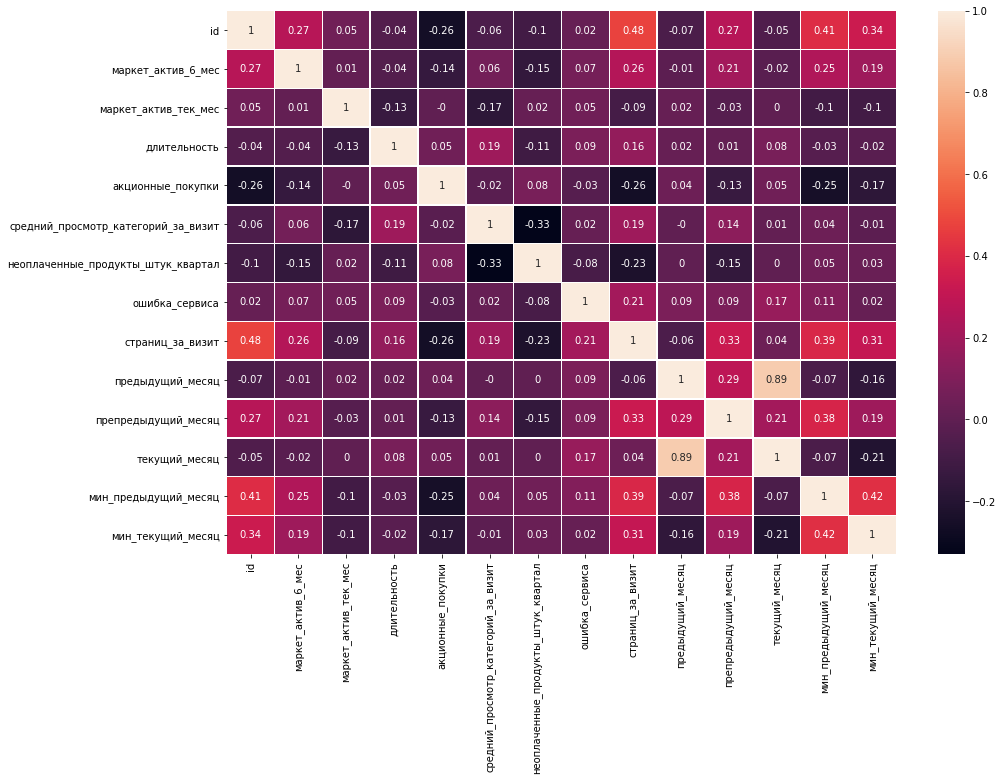

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(merged_df.query(
    'покупательская_активность == "Снизилась"').corr(method='spearman').round(2), linewidths=.5, annot=True);

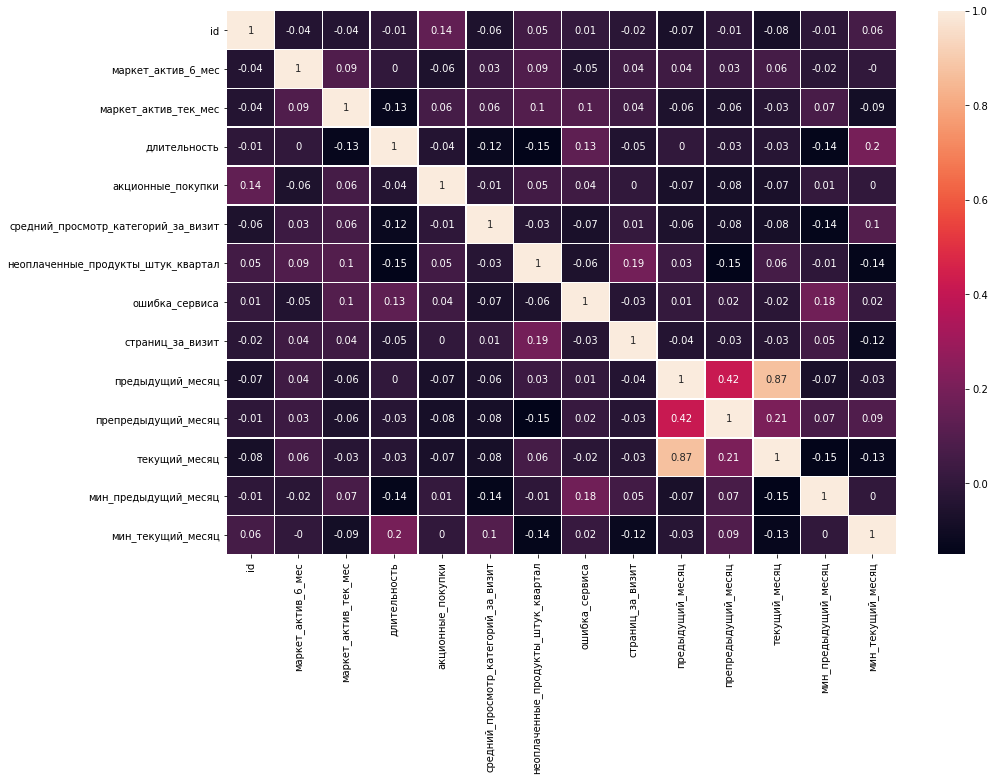

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(merged_df.query(
    'покупательская_активность == "Прежний уровень"').corr(method='spearman').round(2), linewidths=.5, annot=True);

Коэффицентов корреляции выше 0.9 у нас не наблюдается, следовательно, можем заключить, что мульиколлинеарности среди признаков нет.

Визуализируем единсветнную сильную линейную связь между признаками 'предыдущий_месяц' и 'текущий_месяц' 

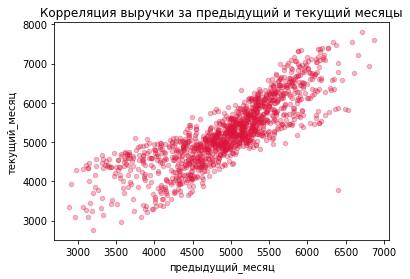

In [41]:
merged_df.plot(x='предыдущий_месяц', y='текущий_месяц', kind='scatter', alpha=0.3, c=np.array(['crimson']))
plt.title('Корреляция выручки за предыдущий и текущий месяцы')
plt.xlabel('предыдущий_месяц')
plt.ylabel('текущий_месяц');

<font color='green' size=+1><b>Вывод по результатам корреляционного анализа</b></font><br>

В нашем наборе данных нет сильной прямой линейной связи, единственная зависимость наблюдается между столбцами 'предыдущий_месяц' и 'текущий_месяц' - корреляция 0.88. Остальные признаки либо не имеют связи вообще, либо имеют - но слабую/очень слабую.

<font color='green' size=+2><b>Использование пайплайнов</b></font><br>

In [42]:
merged_df = merged_df.set_index('id')
merged_df.head(15)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,мин_предыдущий_месяц,мин_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


In [43]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = merged_df.drop(['покупательская_активность'], axis=1)
y = merged_df['покупательская_активность'].apply(lambda x: 1 if x == 'Снизилась' else 0)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

X_train.shape, X_test.shape

# списки с названиями признаков
ohe_columns = ['популярная_категория',
               'маркет_актив_тек_мес',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит']

ord_columns = ['тип_сервиса',
               'разрешить_сообщать']

num_columns = ['маркет_актив_6_мес',
               'длительность',
               'акционные_покупки',
               'текущий_месяц',
               'предыдущий_месяц',
               'препредыдущий_месяц',
               'мин_текущий_месяц',
               'мин_предыдущий_месяц']

# пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['да', 'нет']], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    
    # словарь для модели DecisionTreeClassifier
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
     # словарь для модели KNeighborsClassifier
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
    
    # словарь для модели LogisticRegression
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

gs = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise'
)
gs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', gs.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'маркет_актив_тек_мес',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_кв...
                 

In [44]:
another_param = [
    {'models': [SVC(random_state=RANDOM_STATE)],
     'models__C':[0.1,1,10,100,1000],
     'models__kernel':['rbf', 'poly', 'sigmoid', 'linear'],
     'models__degree':[1,2,3,4,5,6],
     'models__gamma':[1,0.1,0.01,0.001,0.0001],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    another_param, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'маркет_актив_тек_мес',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_кв...
                 

Лучше всего себя показала LogisticRegression с параметрами (C=1, penalty='l1', random_state=42, solver='liblinear'). Метрика для данной модели - recall, потому что нам важно минимизировать количество ошибок FN. Важно идентифицировать как можно больше покупателей, у которых может снизится покупательская способностью.

In [45]:
y_test_pred = gs.best_estimator_.predict(X_test)
print(f'Метрика recall на тестовой выборке: {recall_score(y_test, y_test_pred)}')

Метрика recall на тестовой выборке: 0.7967479674796748


<font color='green' size=+2><b>Анализ важности признаков</b></font><br>

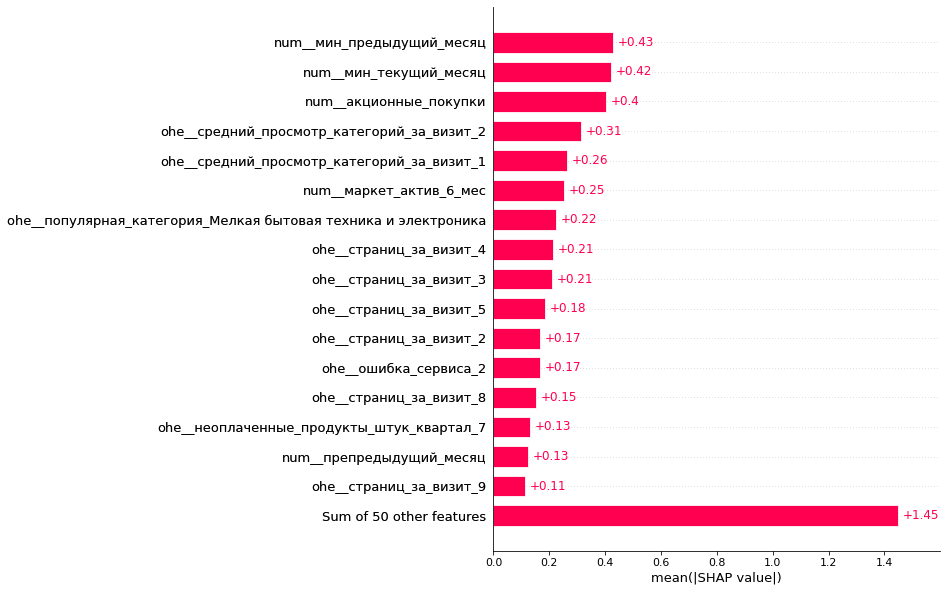

In [46]:
x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(gs.best_estimator_.named_steps['models'], x_Train)

x_Test = pipe_final.named_steps['preprocessor'].transform(X_test)

features_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

x_Test = pd.DataFrame(x_Test, columns=features_names)

shap_values=explainer(x_Test)

shap.plots.bar(shap_values, max_display=17) 

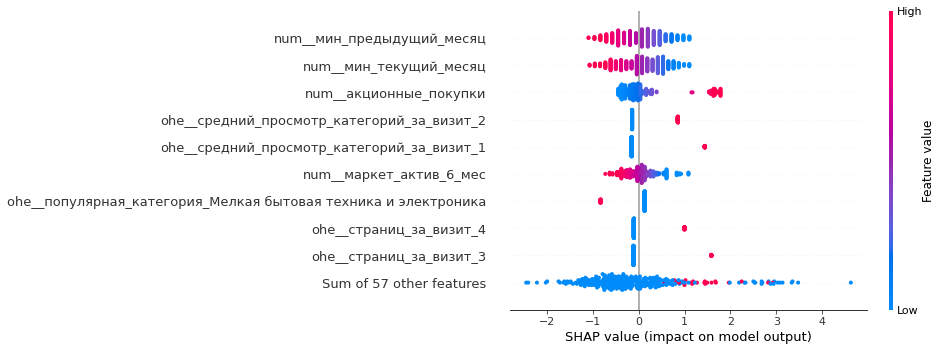

In [47]:
X_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

another_explainer = shap.LinearExplainer(gs.best_estimator_.named_steps['models'], X_Train)

X_Test = pipe_final.named_steps['preprocessor'].transform(X_test)

another_features_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_Test = pd.DataFrame(X_Test, columns=features_names)

shap_values = explainer(X_Test)

shap.plots.beeswarm(shap_values) 

<font color='green' size=+1><b>Выводы по результатам анализа важности признаков</b></font><br>

Наименее важные признаки для модели:
- страниц_за_визит
- препредыдущий_месяц
- неоплаченные_продукты_штук_квартал

Наиболее важные признаки для модели:
- мин_предыдущий_месяц
- мин_текущий_месяц
- акционные_покупки

Признаки мин_предыдущий_месяц и мин_текущий_месяц - при снижении значения увеличивают вероятность отнесения покупательской активности к классу 1. А вот акционные покупки - напротив, при увеличении - соответственно увеличивает вероятность отнесения активности к классу 1.

Из этого можно сделать вывод, что признаки отображающие длительность присутствия пользователя на сайте - очень важный фактор. Также, логично что покупатели хорошо воспринимают акции, и совершают такие покупки. Нужно более грамотно и тщательно продумать процесс, периодичность и объемы акций, что бы клиентов это привлекало, но в то же время - пользователи не ждали только скидок и акций, а были активными покупателями всегда. Возможно, стоит персонализировать скидки (акции), для пользователей, которые и так активно совершают покупки, так же - рассмотреть такие предложения для новых пользователей (но сделать эти акции/скидки меньше, чем у предыдущей категории)

<font color='green' size=+2><b>Сегментация покупателей</b></font><br>

In [48]:
res_predict = pd.Series(gs.best_estimator_.predict_proba(X_test)[:,1], name='вероятность_снижения')
itog_df = pd.concat([money_df, res_predict], axis=1)
len(itog_df)

1300

In [49]:
itog_df = itog_df.dropna(axis=0)
len(itog_df)

324

In [50]:
list_=[]

for el in y_test_pred:
    if el == 1:
        list_.append('Снизилась')
    else:
        list_.append('Прежний уровень')

In [51]:
X_test['покупательская_активность'] = list_
X_test['вероятность_снижения'] = gs.best_estimator_.predict_proba(X_test)[:,1]
X_test.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,мин_предыдущий_месяц,мин_текущий_месяц,покупательская_активность,вероятность_снижения
id,,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,Прежний уровень,0.031322
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,Снизилась,0.959032
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,Прежний уровень,0.090120
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,Снизилась,0.666470
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,Снизилась,0.536382


In [52]:
segment_df = pd.merge(X_test,money_df, on='id', how='inner')
segment_df

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,мин_предыдущий_месяц,мин_текущий_месяц,покупательская_активность,вероятность_снижения,прибыль
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,Прежний уровень,0.031322,4.69
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,Снизилась,0.959032,2.75
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,Прежний уровень,0.090120,3.16
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,Снизилась,0.666470,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,Снизилась,0.536382,4.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,215429,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4,3662.0,4488.0,4158.6,11,10,Снизилась,0.960137,3.71
320,216233,премиум,да,3.9,4,1048,0.21,Техника для красоты и здоровья,3,0,6,14,4325.0,4553.0,4257.4,15,17,Прежний уровень,0.043096,4.62
321,215716,стандарт,да,2.4,4,952,0.30,Техника для красоты и здоровья,3,5,2,3,3067.0,4165.0,3343.9,13,14,Снизилась,0.867265,4.07
322,216141,стандарт,нет,4.0,4,748,0.28,Косметика и аксесуары,4,0,4,9,5660.5,4885.0,6462.6,14,10,Прежний уровень,0.146842,1.97


Сегментируем клиентов по слудующиму принципу:

! ! ! - наиболее ценные клиенты, прибыль от которых более 4, и вероятность снижения более 0.6, то есть нам нужно как можно сильнее стараться их удержать

! ! - клиенты, которые приносят прибыль более 4, но вероятность снижения менее 0.6, так же стоит уделить им внимание, но меньше, поскольку они не стремятся уходить он нас к конкурентам

! - остальные клиенты, прибыль от которых менее 4, их мы можем порадовать какими-либо поадрками и акциями, но чисто символическими.

In [53]:
def category(row):
    if row['прибыль'] > 4 and row['вероятность_снижения'] > 0.6:
        return('! ! !')
    elif row['прибыль'] > 4 and row['вероятность_снижения'] < 0.6:
        return('! !')
    else:
        return('!')
        
segment_df['категория'] = segment_df.apply(category, axis=1)
important_client_df = segment_df.query('категория == "! ! !"')
important_client_df.head()

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,...,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц,мин_предыдущий_месяц,мин_текущий_месяц,покупательская_активность,вероятность_снижения,прибыль,категория
12,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,...,4,5253.5,4715.0,5633.1,8,9,Снизилась,0.970804,4.18,! ! !
18,215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,...,4,4045.0,4963.0,4206.2,11,10,Снизилась,0.940232,4.50,! ! !
21,215484,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,...,3,5059.0,4267.0,5018.7,5,7,Снизилась,0.902566,5.64,! ! !
38,215496,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,...,4,5020.0,4896.0,5237.1,11,11,Снизилась,0.964762,4.64,! ! !
47,215666,стандарт,да,3.5,5,703,0.22,Товары для детей,2,2,...,2,4945.0,4138.0,5150.4,6,10,Снизилась,0.972887,4.02,! ! !


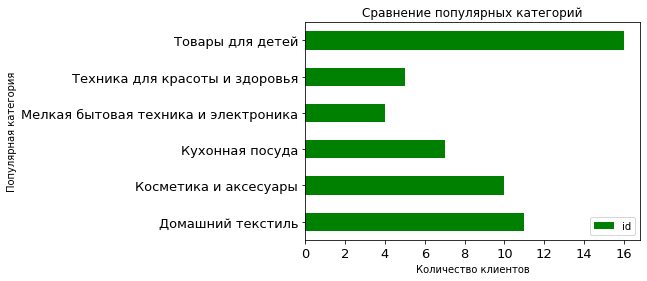

In [54]:
important_client_df.groupby('популярная_категория').agg({'id':'count'}).plot(kind='barh', color='green', fontsize=13)
plt.title('Сравнение популярных категорий')
plt.xlabel('Количество клиентов')
plt.ylabel('Популярная категория')
plt.show()

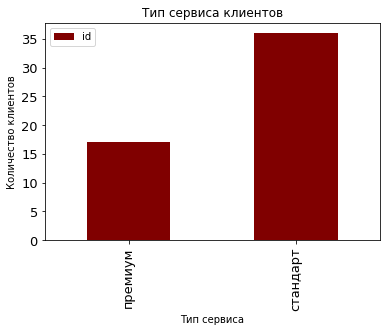

In [55]:
important_client_df.groupby('тип_сервиса').agg({'id':'count'}).plot(kind='bar', color='maroon', fontsize=13)
plt.title('Тип сервиса клиентов')
plt.xlabel('Тип сервиса')
plt.ylabel('Количество клиентов')
plt.show()

<font color='green' size=+1><b>Итоги сегментации и предложения</b></font><br>

Мы определили самых важных для нашего внимания клиентов, и самые популярные категории для них. Топ 3 категорий:
    - Товары для детей
    - Домашний текстиль
    - Косметика и аксессуары
    
    Полагаю, что можно предоставить клиентам дополнительные скидки в этих категориях, персональные рекламные рассылки внутри сегмента по популярным категориям. Предложить различные купоны. Что бы это сильно не ударило по бюджету организации, можно сделать скидки в формате "На вторую покупку в категории, скидка Х%", тем самым, может получится увеличить и продажи и прибыль, так еще и удержать дорогих для нам клиентов.
    
    Также, больше половины клиентов не имеют премиум подписки, можно раздать ее внутри это категории, к примеру, на месяц. А при продлении на период от 2-ух месяцев, скидка на стоимость подписки Х%.

<font color='green' size=+2><b>Вывод</b></font><br>

В рамках задачи нам поступили данные о покупателях и прибыльности Интернет-магазина «В один клик».

Данные не содержали пропусков, но все же мы немного с ними поработали - исправили некоторые орфографические ошибки, избавились от выбросов. Отобрали клиентов с покупательской активностью не менее 3 месяцев. Изучили корреляцию признаков в разрезе покупательской активности.

После этого, мы приступили к поиску лучшей модели прогнозирования целевого признака 'покупательская_активность', и метода ее оценки с помощью pipeline. В нем мы перерали и обучили 4 модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и  SVC. Для этого мы поделили данные на тренировочную выборку - для обучения, и тестовую - для пресказания результата. 

Лучше всего себя показала LogisticRegression с параметрами (C=1, penalty='l1', random_state=42, solver='liblinear'). Мы выбрали метрику recall, т.к. нам важно минимизировать количество ошибок FN. Важно идентифицировать как можно больше покупателей, у которых может снизится покупательская способность. Точность модели на тренировочной выборке составила 0.9 а на тестовой - почти 0.8.

Далее мы сегментировали покупателей на 3 группы:

! ! ! - наиболее ценные клиенты, прибыль от которых более 4, и вероятность снижения более 0.6, то есть нам нужно как можно сильнее стараться их удержать

! ! - клиенты, которые приносят прибыль более 4, но вероятность снижения менее 0.6, так же стоит уделить им внимание, но меньше, поскольку они не стремятся уходить он нас к конкурентам

! - остальные клиенты, прибыль от которых менее 4, их мы можем порадовать какими-либо поадрками и акциями, но чисто символическими.

И сформировали некоторые предложения, которые можно рассмотреть для удержания самой важной для магаззина категории - ! ! !:
- релизовать скидочные программы в интересующих пользователей категориях;
- сделать персональные рассылки с купонами и спецпреложениями;
- рассмотреть возмоность бесплатного предоставления подписки преимум на небольшой срок, для стимулирования покупательской активности.